<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>

In [1]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            new_data = []
            for i in range(0, dimensions):
                new_data.append([0])
                
            if ord(c)-ord('A') < 26 and ord(c)-ord('A') >= 0:
                new_data[ord(c)-ord('A')] = [1]
            else:
                if c == " ":
                    new_data[-1] = [1]
            data.append(new_data)
            if max_len != None:
                if len(data) >= max_len:
                    print("all loaded")    
                    return data
                    
    print("all loaded")  
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x, temperature):
    inp = x/temperature
    p = np.exp(inp - np.max(inp))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

#def cross_entropy(target, x):
#    data = np.clip(x, 1, 

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z, 0.5)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data, max_steps=0):
        self.layers[0].forward_pass(input_data, max_steps)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]        # Takes in the output of the previous layer. h[-1] is the hidden state of the last timestep of the layer
            self.layers[i].forward_pass(prev_layer_out, max_steps)
            
        return self.layers[-1].y
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps, t):
        gradient, loss = self.layers[-1].der_MSE(target)
        #print("MSE gradient: " + str(gradient))
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps, t)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps, t)
        return loss
    
    def predict(self, input_data):
        self.clear_memory()
        next_letter = []
        out_letter = []
        start = int(np.random.uniform(0, len(input_data)-400))
        for i in range(start, start+400):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(0, 500):
            maximum = 0;
            max_index = 0;
            """for k in range(0, self.layers[0].input_size):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k"""
            max_index = np.random.choice(len(next_letter), p=np.squeeze(softmax(next_letter, 0.05).T))
            out_letter = np.zeros(next_letter.shape)
            out_letter[max_index,0] = 1
            if max_index < 26:
                print_output += chr(ord('A')+max_index)
            else:
                if max_index == 26:
                    print_output += ' '
                    
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # M
        self.output_size = output_size # N
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True, var=1) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        self.y       = np.empty((output_size, 1))
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.mWz = np.zeros((output_size, input_size))
        self.vWz = np.zeros((output_size, input_size))
        self.mWr = np.zeros((output_size, input_size))
        self.vWr = np.zeros((output_size, input_size))
        self.mWh = np.zeros((output_size, input_size))
        self.vWh = np.zeros((output_size, input_size))
        
        self.mUz = np.zeros((output_size, output_size))
        self.vUz = np.zeros((output_size, output_size))
        self.mUr = np.zeros((output_size, output_size))
        self.vUr = np.zeros((output_size, output_size))
        self.mUh = np.zeros((output_size, output_size))
        self.vUh = np.zeros((output_size, output_size))
        
        self.mbz = np.zeros((output_size, 1))
        self.vbz = np.zeros((output_size, 1))
        self.mbr = np.zeros((output_size, 1))
        self.vbr = np.zeros((output_size, 1))
        self.mbh = np.zeros((output_size, 1))
        self.vbh = np.zeros((output_size, 1))
        
        self.epsilon = 0.000000001
        
        #self.errors  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
    def weights_init(self, rows, cols, bias=False, var=0.1):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(-var,var,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data, max_steps=0):
        
        self.inputs = np.concatenate((self.inputs, [input_data]), axis=0)
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.zeros((self.output_size, 1))
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz      #Nx1
        new_z = sigmoid(new_z)
        self.z = np.concatenate((self.z, [new_z]), axis=0)

        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = sigmoid(new_r)
        self.r = np.concatenate((self.r, [new_r]), axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.Uh @ (new_r * prev_h) + self.bh
        new_h_tilde = np.tanh(new_h_tilde)
        self.h_tilde = np.concatenate((self.h_tilde, [new_h_tilde]), axis=0)
        
        new_h = new_z * prev_h + (1 - new_z) * new_h_tilde
        self.h = np.concatenate((self.h, [new_h]), axis=0)
        if self.last_activation != None:
            self.y = activation_function(new_h, self.last_activation)
        else:
            self.y = new_h
        
        """if max_steps != 0:
            if len(self.z) > max_steps:
                self.z = np.delete(self.z, 0, 0)
            if len(self.r) > max_steps:
                self.r = np.delete(self.r, 0, 0)
            if len(self.h_tilde) > max_steps:
                self.h_tilde = np.delete(self.h_tilde, 0, 0)
            if len(self.h) > max_steps:
                self.h = np.delete(self.h, 0, 0)
            if len(self.h) > max_steps:
                self.inputs = np.delete(self.inputs, 0, 0)"""
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        self.inputs  = np.empty((0,self.input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.mWz = np.zeros((self.output_size, self.input_size))
        self.vWz = np.zeros((self.output_size, self.input_size))
        self.mWr = np.zeros((self.output_size, self.input_size))
        self.vWr = np.zeros((self.output_size, self.input_size))
        self.mWh = np.zeros((self.output_size, self.input_size))
        self.vWh = np.zeros((self.output_size, self.input_size))
        
        self.mUz = np.zeros((self.output_size, self.output_size))
        self.vUz = np.zeros((self.output_size, self.output_size))
        self.mUr = np.zeros((self.output_size, self.output_size))
        self.vUr = np.zeros((self.output_size, self.output_size))
        self.mUh = np.zeros((self.output_size, self.output_size))
        self.vUh = np.zeros((self.output_size, self.output_size))
        
        self.mbz = np.zeros((self.output_size, 1))
        self.vbz = np.zeros((self.output_size, 1))
        self.mbr = np.zeros((self.output_size, 1))
        self.vbr = np.zeros((self.output_size, 1))
        self.mbh = np.zeros((self.output_size, 1))
        self.vbh = np.zeros((self.output_size, 1))
        #self.errors  = np.empty((0,self.input_size,1))  # TxMx1, inputs(t) = Mx1
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(self.y-target) * softmax(self.y, 0.5), np.power(target - self.y, 2)
        return 2*(self.y-target), np.power(target - self.y, 2)

     

<img src="images\article_derivative_image.png" width=800>

In [2]:
class Layer(Layer):    
    
    def descent(self, gradient, input_data, learning_rate, max_steps, t):
        
        first_index = 0 if len(self.h) <= max_steps else len(self.h) - max_steps
        step = 1
        
        d0 = gradient
        d1=0
        d2=0
        d3=0
        d4=0
        d5=0
        d6=0
        d7=0
        d8=0
        d9=0
        d10=0
        d11=0
        d12=0
        d13=0
        d14=0
        d15=0
        d16=0
        d17=0
        d18=0
        d19=0
        d20=0
        dx=0
        dh=0
        dWz=0
        dWr=0
        dWh=0
        dUz=0
        dUr=0
        dUh=0
        dbz=0
        dbr=0
        dbh=0
        
        
        while len(self.h) - step > first_index:
            x = np.array(input_data[len(self.h) - step])
            prev_h = self.h[len(self.h) - step-1] if len(self.h) - step-1 >= 0 else np.zeros((self.output_size, 1))
            h_tilde = self.h_tilde[len(self.h) - step]
            h = self.h[len(self.h) - step]
            z = self.z[len(self.h) - step]
            r = self.r[len(self.h) - step]
            
            d1 = d0 * z
            d2 = d0 * prev_h
            d3 = d0 * h_tilde
            d4 = -d3
            d5 = d2 + d4
            d6 = d0 * (1-z)
            d7 = d5 * (z * (1-z))
            d8 = d6 * (1 - np.power(h_tilde, 2))
            
            d9 = self.Wh.T @ d8 
            d10= self.Uh.T @ d8 
            d11= self.Wz.T @ d7
            d12= self.Uz.T @ d7
            d14= d10 * r
            d15= d10 * prev_h
            d16= d15 * (r * (1-r))
            d17= self.Ur.T @ d16
            d13= self.Wr.T @ d16
            
            if step == 1:
                dx = d13 + d11 + d9
            dh = d1 + d14 + d17 + d12
            dWr+= d16 @ x.T
            dWh+= d8 @ x.T
            dWz+= d7 @ x.T
            dUr+= d16 @ prev_h.T
            dUh+= d8 @ (r * prev_h).T
            dUz+= d7 @ prev_h.T
            
            dbh+= d8
            dbr+= d16
            dbz+= d7
            
            d0 = dh
            
            step += 1
        
        oneminusbeta1 = (1 - self.beta1)
        oneminusbeta2 = (1 - self.beta2)
        
        self.mWz = self.beta1 * self.mWz + oneminusbeta1 * dWz
        self.vWz = self.beta2 * self.vWz + oneminusbeta2 * np.power(dWz, 2)
        self.mWr = self.beta1 * self.mWr + oneminusbeta1 * dWr
        self.vWr = self.beta2 * self.vWr + oneminusbeta2 * np.power(dWr, 2)
        self.mWh = self.beta1 * self.mWh + oneminusbeta1 * dWh
        self.vWh = self.beta2 * self.vWh + oneminusbeta2 * np.power(dWh, 2)
        
        self.mUz = self.beta1 * self.mUz + oneminusbeta1 * dUz
        self.vUz = self.beta2 * self.vUz + oneminusbeta2 * np.power(dUz, 2)
        self.mUr = self.beta1 * self.mUr + oneminusbeta1 * dUr
        self.vUr = self.beta2 * self.vUr + oneminusbeta2 * np.power(dUr, 2)
        self.mUh = self.beta1 * self.mUh + oneminusbeta1 * dUh
        self.vUh = self.beta2 * self.vUh + oneminusbeta2 * np.power(dUh, 2)
        
        self.mbz = self.beta1 * self.mbz + oneminusbeta1 * dbz
        self.vbz = self.beta2 * self.vbz + oneminusbeta2 * np.power(dbz, 2)
        self.mbr = self.beta1 * self.mbr + oneminusbeta1 * dbr
        self.vbr = self.beta2 * self.vbr + oneminusbeta2 * np.power(dbr, 2)
        self.mbh = self.beta1 * self.mbh + oneminusbeta1 * dbh
        self.vbh = self.beta2 * self.vbh + oneminusbeta2 * np.power(dbh, 2)
        
        powerbeta1 = (1 - np.power(self.beta1, t))
        powerbeta2 = (1 - np.power(self.beta2, t))
        
        mWz_hat = self.mWz / powerbeta1
        vWz_hat = self.vWz / powerbeta2
        mWr_hat = self.mWr / powerbeta1
        vWr_hat = self.vWr / powerbeta2
        mWh_hat = self.mWh / powerbeta1
        vWh_hat = self.vWh / powerbeta2
        mUz_hat = self.mUz / powerbeta1
        vUz_hat = self.vUz / powerbeta2
        mUr_hat = self.mUr / powerbeta1
        vUr_hat = self.vUr / powerbeta2
        mUh_hat = self.mUh / powerbeta1
        vUh_hat = self.vUh / powerbeta2
        mbz_hat = self.mbz / powerbeta1
        vbz_hat = self.vbz / powerbeta2
        mbr_hat = self.mbr / powerbeta1
        vbr_hat = self.vbr / powerbeta2
        mbh_hat = self.mbh / powerbeta1
        vbh_hat = self.vbh / powerbeta2
        
        self.Wr = self.Wr - learning_rate * mWr_hat / (np.sqrt(vWr_hat) + self.epsilon)
        self.Wh = self.Wh - learning_rate * mWh_hat / (np.sqrt(vWh_hat) + self.epsilon)
        self.Wz = self.Wz - learning_rate * mWz_hat / (np.sqrt(vWz_hat) + self.epsilon)
        self.Ur = self.Ur - learning_rate * mUr_hat / (np.sqrt(vUr_hat) + self.epsilon)
        self.Uh = self.Uh - learning_rate * mUh_hat / (np.sqrt(vUh_hat) + self.epsilon)
        self.Uz = self.Uz - learning_rate * mUz_hat / (np.sqrt(vUz_hat) + self.epsilon)
        self.br = self.br - learning_rate * mbr_hat / (np.sqrt(vbr_hat) + self.epsilon)
        self.bh = self.bh - learning_rate * mbh_hat / (np.sqrt(vbh_hat) + self.epsilon)
        self.bz = self.bz - learning_rate * mbz_hat / (np.sqrt(vbz_hat) + self.epsilon)
        
        return dx
    

In [3]:
network = RNN(0.001)
network.add_layer(27, 100)
network.add_layer(100, 60)
network.add_layer(60, 27, "softmax")

In [4]:
input_data = load_data_txt("FinalText.txt", 27, 9000)

loading data
all loaded


---------------
epoch 0
---------------
epoch 0
learning rate: 0.001
sample 401
output: 
[[0.04507187]
 [0.01835784]
 [0.01151301]
 [0.02786883]
 [0.04718286]
 [0.03549411]
 [0.01038366]
 [0.02998225]
 [0.03005597]
 [0.00825897]
 [0.00753151]
 [0.07035779]
 [0.01728018]
 [0.03688441]
 [0.1015761 ]
 [0.00945433]
 [0.00668052]
 [0.03301689]
 [0.04172609]
 [0.04289341]
 [0.05432935]
 [0.00999653]
 [0.02133811]
 [0.00797324]
 [0.03423932]
 [0.00806806]
 [0.23248477]]
target: 
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1]]
---------------
epoch 0
learning rate: 0.001
sample 1202
output: 
[[0.14468358]
 [0.01857155]
 [0.01894247]
 [0.01326497]
 [0.14322199]
 [0.03667885]
 [0.01314145]
 [0.07326615]
 [0.08070843]
 [0.0069669 ]
 [0.00645674]
 [0.01968769]
 [0.01620211]
 [0.02810964]
 [0.13313069]
 [0.01765083]
 [0.00537553]
 [0.03457738]
 [0.0438587 ]
 [0.05381338]
 [0.01294528]
 [0.01517334]
 [0.01731528]

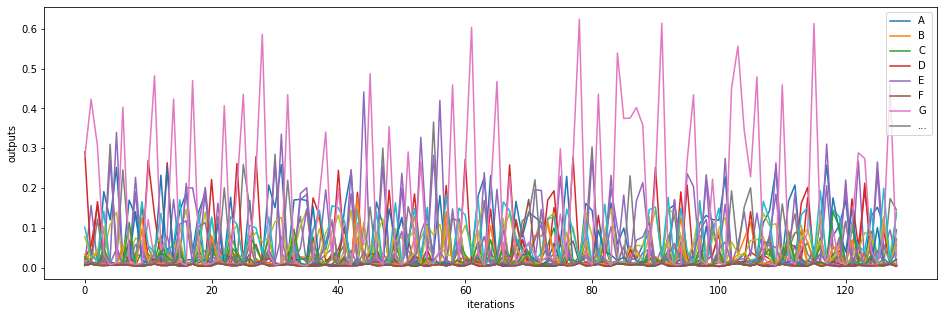

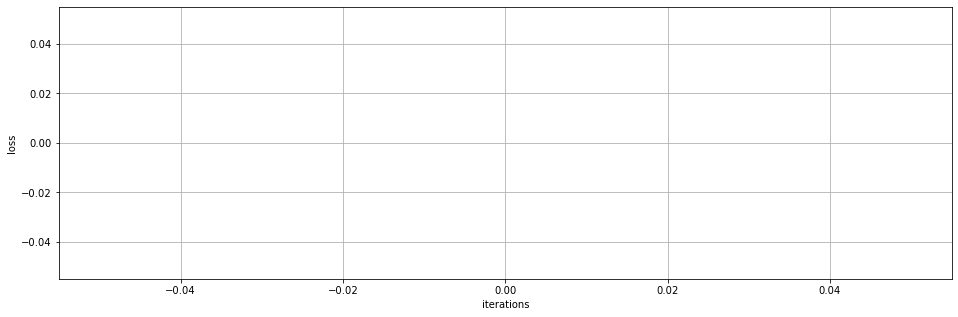

 MON  THE BE SHAN IN AVE THE TO  MEN THE CE CE SHE MAS AN I AN IN A IN THE SAW BE THE HE XON AT HE AN MEN CE HE HE AN OUS THE UN A THE BE THE SY VE A THE A BAT THE SOT MAT THE THE BE HAN A THE I CE AN FOGLP IT DOU EL SHE  UN A TJE THE THE A POZON CAIN THE CO NO ROUT HAN THE SRHAN AN AN A PANT LE BE THE BE THE ME NE TO JONE YOU AN SO HE AQ LVE FAN ON  CO  RON HOQ LO EO THE BE MOIN A THE POLED FO THE HE OU BE IN A A THE THE A GORE LOWE ZON SHE BFEL NO  WHE VOUL THE SO RQEN IT THE FORK THE A BOUH T
---------------
epoch 1
---------------
epoch 2
-----------------
average loss: 
[[0.05735884]
 [0.01146938]
 [0.01901371]
 [0.02850874]
 [0.07002457]
 [0.01567274]
 [0.00791188]
 [0.03163924]
 [0.05067741]
 [0.00127177]
 [0.00534747]
 [0.02559932]
 [0.01679151]
 [0.04713525]
 [0.04617264]
 [0.01437624]
 [0.00050406]
 [0.03701503]
 [0.0453319 ]
 [0.05531075]
 [0.01842289]
 [0.01047315]
 [0.01525624]
 [0.00115041]
 [0.01487461]
 [0.00071926]
 [0.07763027]]


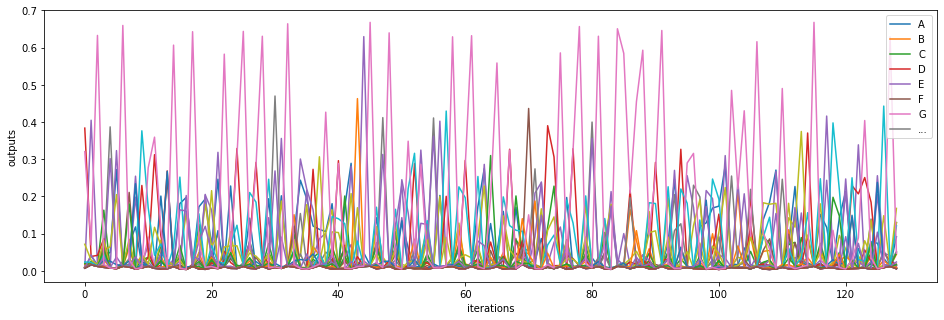

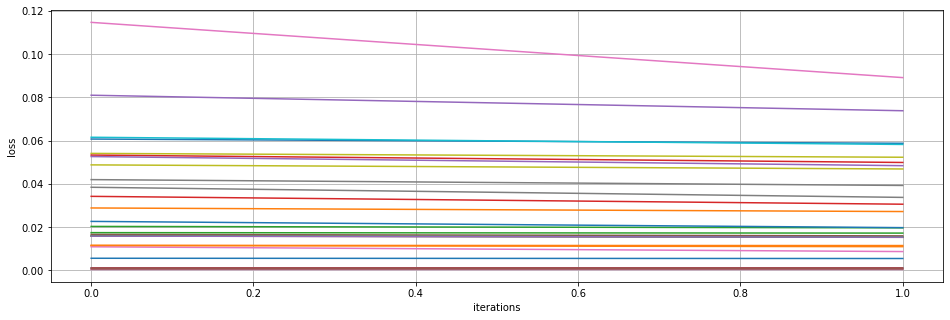

ETPRONCE IND THE BET CREAL I THE BET  WHE AND ONE WITH UNDE ENTING TO CHER I VEN OUR IN EVETING IN AND TO BE IT THE BUT JOTH NOT HE FOORE HE SAID WITH THE BUT IN THE I JOTH THE BUT THE SAID I CONTING I MECATE DE IN AND THAT THE EO THAT BUT I CONTING IN THE PRENCE LIONE IN AND DEREING QOTING IN AND THE CONTING FAITH THE MEREN AND REAKE UNDE RESS IN AND THE MONATGER TO LIUS TO BY THE BET I CAT THE IND AND TO THE CZONCE THE SOOD SXEREN AND CYOZED IND CORNE HE SNVOWNE IN TO GATING THE I OU ANOT KRE 
---------------
epoch 3
---------------
epoch 4
-----------------
average loss: 
[[0.05507949]
 [0.01123936]
 [0.01776175]
 [0.02477911]
 [0.06337045]
 [0.0150708 ]
 [0.00681239]
 [0.02928039]
 [0.04804374]
 [0.00128662]
 [0.00504397]
 [0.02300314]
 [0.01613043]
 [0.04178274]
 [0.04255263]
 [0.0131227 ]
 [0.0005239 ]
 [0.03382176]
 [0.04243573]
 [0.04965122]
 [0.01654395]
 [0.00894197]
 [0.01453366]
 [0.00115711]
 [0.01392672]
 [0.00073418]
 [0.06568152]]


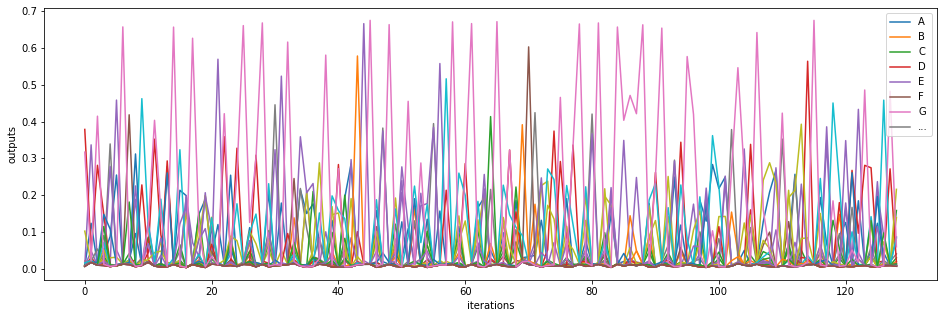

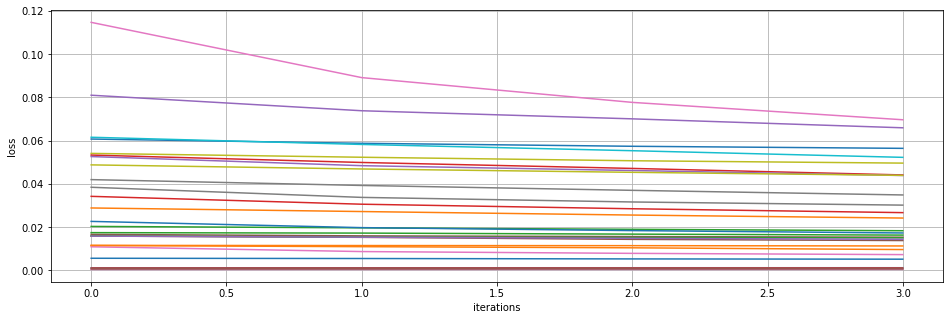

 WAS THE PRESSING NO AND THE HPRINCE BE I THE BUT CONSELS GHNA WOULD I CONSELC BE RAN THE IND A TO OF THE ZING I CONSELN AND MOREN HE SAID TO ME IND TO I CONTED IND AND JOTHE IN A CONT GIT IN THE PRINCE TO BE HOR THE IND LOT NOT HX SZAS BOTH  I AL TO BE ANNE I CONSELS CHAUT SHAT IND EVEN TO IND AND THE WITH TO SHE IND A TO SHMANT IN THE IND AHE COULD TO IND A TULE IN TO ME HIS SO LY THE IND AND THE WELY I UL MMDELVE BE THE BEEN THE IN THE IND AME LISZ AND COULD IN AN TO MY LEFE AND SOME THAT TO 
---------------
epoch 5
---------------
epoch 5
learning rate: 0.001
sample 401
output: 
[[0.02047549]
 [0.01496186]
 [0.01688667]
 [0.04435813]
 [0.01812981]
 [0.01532023]
 [0.01503033]
 [0.01497169]
 [0.01522508]
 [0.0149549 ]
 [0.01496412]
 [0.0264414 ]
 [0.01511595]
 [0.23904269]
 [0.01508868]
 [0.01517992]
 [0.01495546]
 [0.01714184]
 [0.01882214]
 [0.02017153]
 [0.01495718]
 [0.01588819]
 [0.0149704 ]
 [0.0149549 ]
 [0.01495518]
 [0.0149549 ]
 [0.32208135]]
target: 
[[0], [0], [0], [0], [

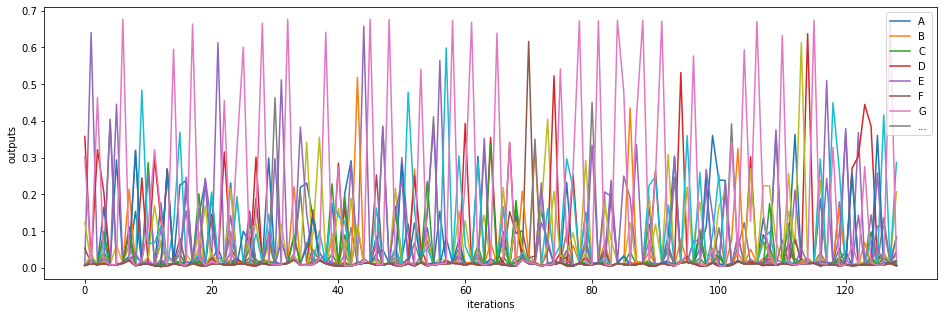

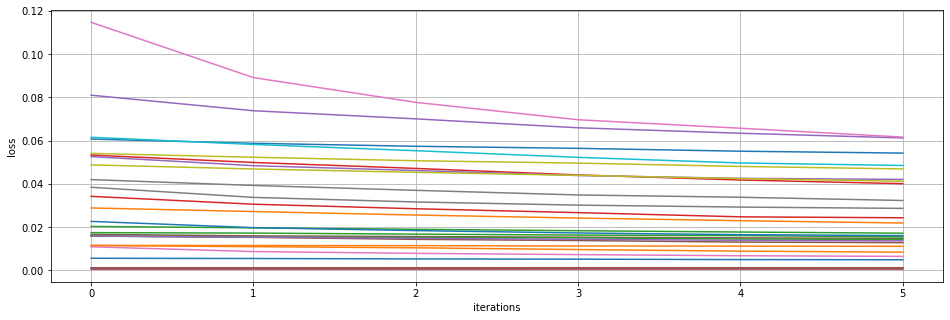

 SORE IND AND THE PRINCE NOT KNE WOULD SO IT HE SAID THE GONT IND THAT THE NESSATED TO GAT THE AND THE MEN A TO CHAL IVE IN THAT EUST IN THE  SAID THE BOON  AND THE RECOME  AND THE CONAED TO IND THE IN THE IN THE UMDENGED TO CANT TO  VOST THE IN SO JUST  YOU WOULD BE THE MY I MEN THE AND THE QUIST NATHE SMED I MAN AND TO CANT MORE NOT QUEALINE I TO YOU WERE NAT IN AND TO YOU WAN KNE WOULD TO AND IN TO YOU WITH THE BENE HE SAID THE WITH THE MEN AND THE UNDENGENE TO BE TO OF THE BNE TO YOU WAN THE
---------------
epoch 7
---------------
epoch 8
-----------------
average loss: 
[[0.05156431]
 [0.0111024 ]
 [0.01649702]
 [0.02272391]
 [0.05608073]
 [0.01470052]
 [0.00635247]
 [0.02794437]
 [0.04489857]
 [0.00130468]
 [0.00477349]
 [0.01994505]
 [0.01519208]
 [0.0367841 ]
 [0.03926934]
 [0.01194193]
 [0.00054617]
 [0.03009825]
 [0.03880324]
 [0.04431237]
 [0.01499824]
 [0.0080831 ]
 [0.01419221]
 [0.00117885]
 [0.01294223]
 [0.00076399]
 [0.05676509]]


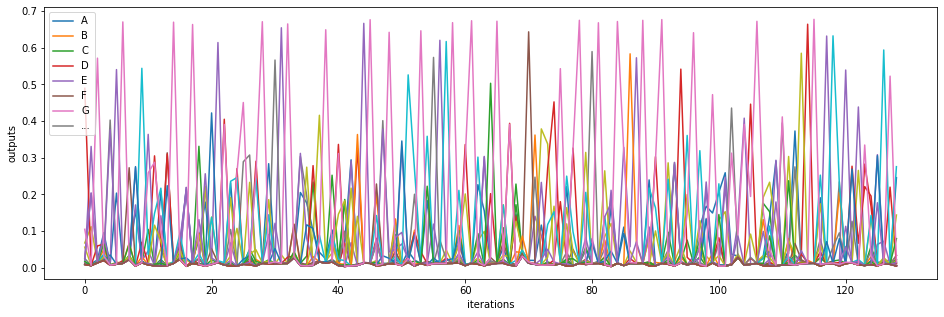

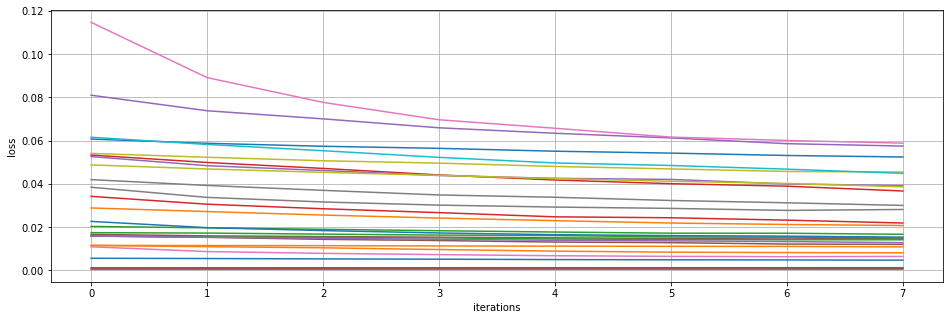

EST KE I THE PRINCE AND MONT BE HER MING AND I CANT I HAVE BOTH THE BENOTE AND IN THE GONT I MEN THE BANED TO THE BEAT AND TO SHE CONT SPEAYNE  IN THE PRINCE PRINCE AND DO YOU ALONED CHAS TO COCRICH TO SHE BENUT TO IN CONTE AN THE XONT IND THE PRINCE BUT THE GONT I MANTION AND THE JONT HIS BEEN CONTERS IN FINCE  A SO ING BE HOR COULD I CONTITH THE NAED TO SHE BEEN CANT IN THE PRINCE IS AN ENDERED BE THE PRINCE AND GATED AND ANNA PVLOVNA TO LO HE SAID IT I THE HOW I I HAVE TO BEAT TO BUT TO LO HE
---------------
epoch 9
---------------
epoch 10
---------------
epoch 10
learning rate: 0.001
sample 401
output: 
[[0.01244053]
 [0.01215983]
 [0.01216072]
 [0.01217282]
 [0.01216656]
 [0.01216085]
 [0.01215998]
 [0.01216168]
 [0.01216153]
 [0.01215965]
 [0.01215965]
 [0.01222495]
 [0.0121612 ]
 [0.02647894]
 [0.01215999]
 [0.0121665 ]
 [0.01215965]
 [0.01747384]
 [0.01217475]
 [0.01291606]
 [0.01215971]
 [0.01215965]
 [0.01215968]
 [0.01215965]
 [0.01215965]
 [0.01215965]
 [0.66306232]]
targe

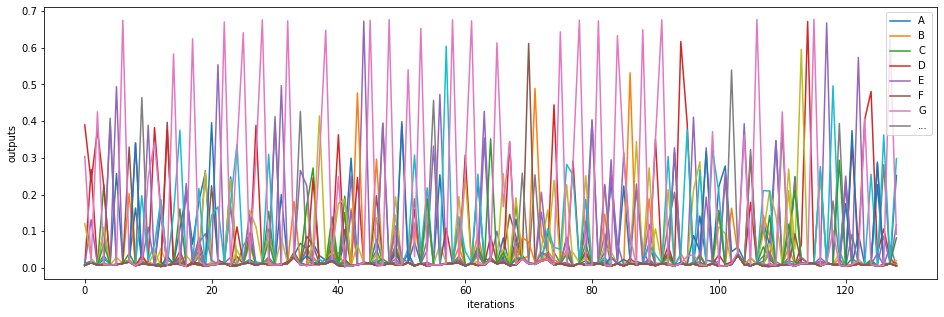

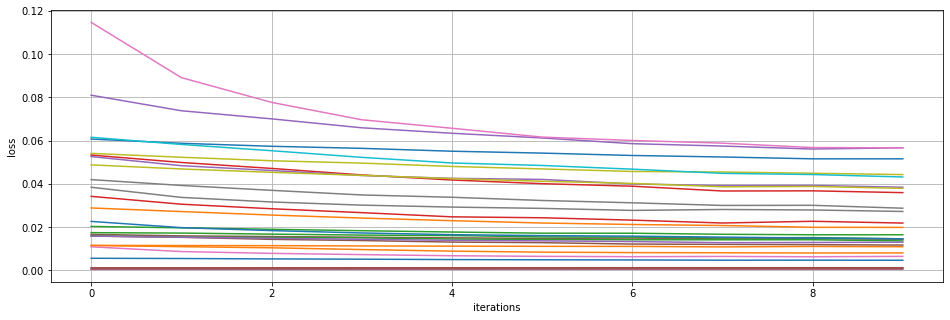

TO IT I CAN  LOFT BUT DIS IN THAT IN THE BUONT HIM SAID KNEW THE PRINCE AND TO SOUID I AM I THE BANE ZOULD NOT WINW THE JOSS IN THE BBENE COULD NOT IS IN THE BUONT OF TO SUCHGER I WOULD NA MYOU HAVE I DONT IN THAT IN THE BUONT IN THE BUONT OF TO YOU AND TO SHELE IN THE BANE THE BTEN BUT OUR XDOWN MAN A SZALY  IN THE BQEE NATING THE BAZE MENTION HAT IS AN AND TO SOUI DATING TO CHAR I AM I TO HE IND THE BEMEN BUT TO SUUHE SHE I DONT IN A WORD I A TO HE THE VENY YOUR FRAILL I AM IN THE BUROTING IT 
---------------
epoch 11
---------------
epoch 12
-----------------
average loss: 
[[0.05064749]
 [0.01051424]
 [0.01578678]
 [0.0212002 ]
 [0.05420289]
 [0.01407457]
 [0.00665826]
 [0.02683458]
 [0.04185426]
 [0.00131259]
 [0.00461175]
 [0.01964249]
 [0.0142772 ]
 [0.03511121]
 [0.0371886 ]
 [0.01155127]
 [0.0005548 ]
 [0.02877967]
 [0.03668216]
 [0.04241072]
 [0.01451733]
 [0.00788544]
 [0.01342108]
 [0.00119321]
 [0.01279693]
 [0.00077425]
 [0.05407528]]


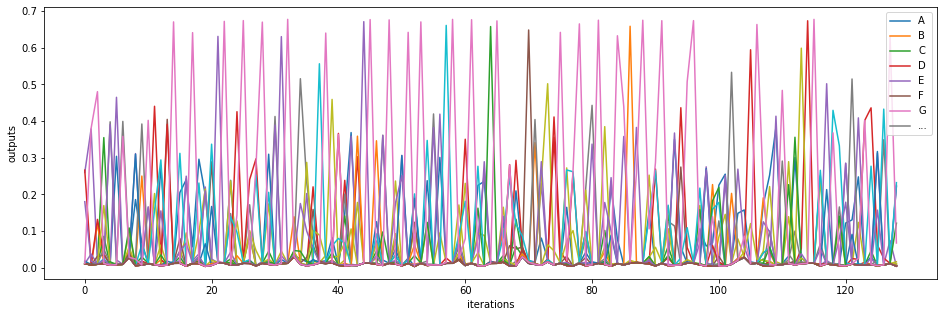

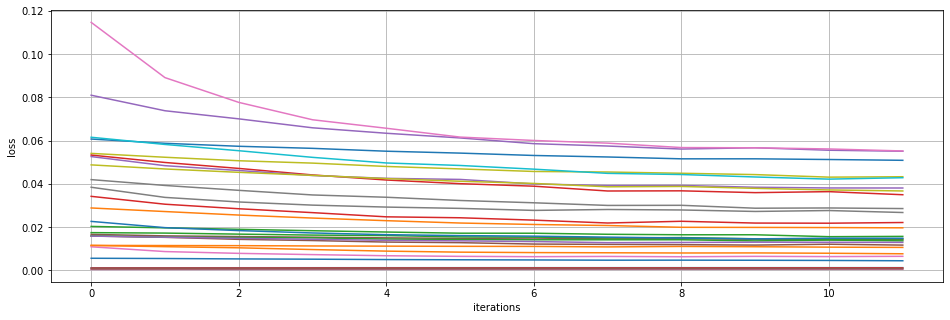

INCE IT HOW IN THE PRINCE IS THE BURN OF TO SUCH MEN IT IN THAT IND TO SHOW IN TO SECURE AND THE PRINCE I CONTXERSATION OF THE GENTIOUS AND TO IND HAS PAITE OF TO SHOW IT NATULX SHE CHIRNW IT NOT IN TO SHE IS QUTOTH TO LOLVE THE BEEN EMPRESSPED AND THE KNEW KNE US AND TO SO IN TO YOU ALO A SAID AND INCOTE MIND THE BEEN THE PRINCE IT AND TO TO SHE SADD AND TO YOU WHAT IN TO SHOW IGATION OF MY IT NOT I AS PLAIND  THE PRINCE IT TO SUCH MEN INDERED THE VERY YOU HAVE I AI AND THE PRINCE I  AND THE GL
---------------
epoch 13
---------------
epoch 14
-----------------
average loss: 
[[0.05126037]
 [0.01067017]
 [0.01570146]
 [0.02166732]
 [0.05460184]
 [0.01415634]
 [0.00659286]
 [0.02670203]
 [0.04203819]
 [0.00131828]
 [0.00446162]
 [0.01943132]
 [0.01427469]
 [0.03561226]
 [0.0375045 ]
 [0.01189469]
 [0.00056875]
 [0.02803555]
 [0.03677531]
 [0.04240972]
 [0.01465993]
 [0.00786709]
 [0.01360749]
 [0.00119723]
 [0.01268824]
 [0.00078603]
 [0.05446566]]


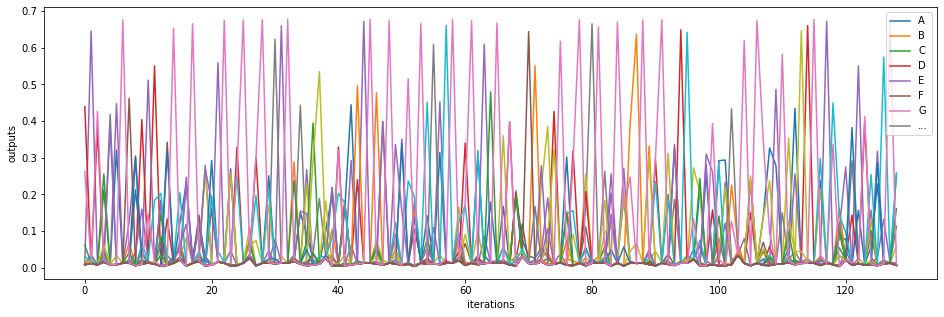

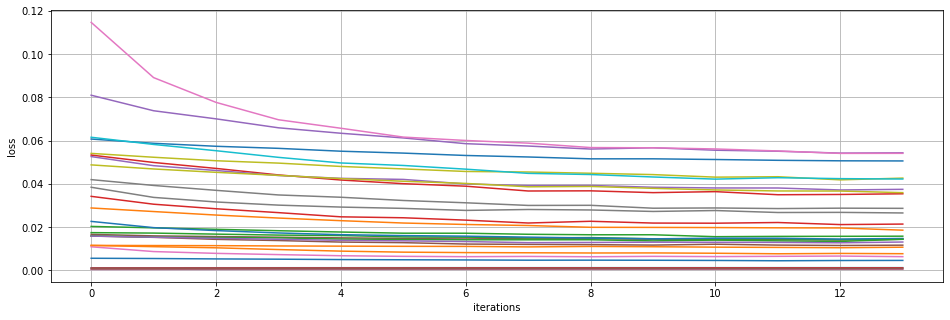

ENTION AND IBCATE THE THE EMPRESS BEEUNG TO SPEAID THING MENED THE BANE THE BUOLE  INHE TO BE TOLLY FOR THE BEAT I UP COMING I WOME HE SAID THE PRINCE BEYONE MY YOU WELL IN THE LESS BUT THE THE BUOLE I BUT TO I SHOWW THE ONS THE BENES IN AD YOU WILL IN A TOO THE BXOOLE ELALE AND THE QUEWING HOW IN A MOON AND THE INFAND IN A MOON DONT IND THE DIDLING IN A WOME BE TO BE RESCIPTE DESRED THE BESENINE JO HE WORAN SO YOU ALO I CANT MATED THE BUONA AND THE  IN THE CHILD PGING AND IN A MORE SAID THE PRI
---------------
epoch 15
---------------
epoch 15
learning rate: 0.001
sample 401
output: 
[[0.01222222]
 [0.01221601]
 [0.01223742]
 [0.02162756]
 [0.0122204 ]
 [0.01221735]
 [0.01221519]
 [0.01221528]
 [0.01223007]
 [0.01221441]
 [0.01221475]
 [0.01241692]
 [0.01234337]
 [0.02009897]
 [0.01222942]
 [0.01222066]
 [0.01221441]
 [0.01235044]
 [0.01243136]
 [0.01221705]
 [0.01223087]
 [0.01223941]
 [0.01222286]
 [0.01221441]
 [0.01221441]
 [0.01221441]
 [0.66431036]]
target: 
[[0], [0], [0], [0],

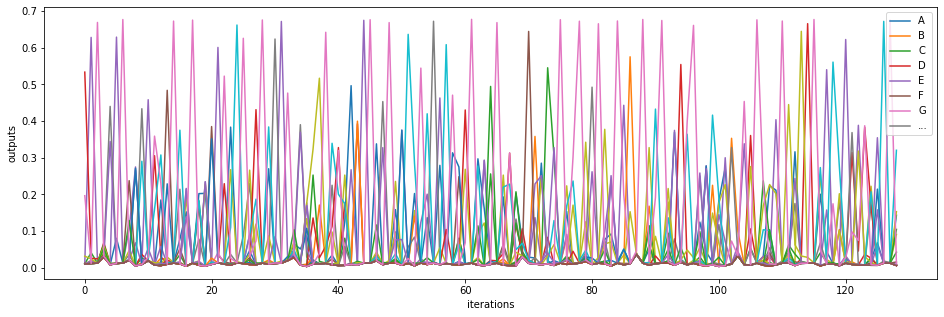

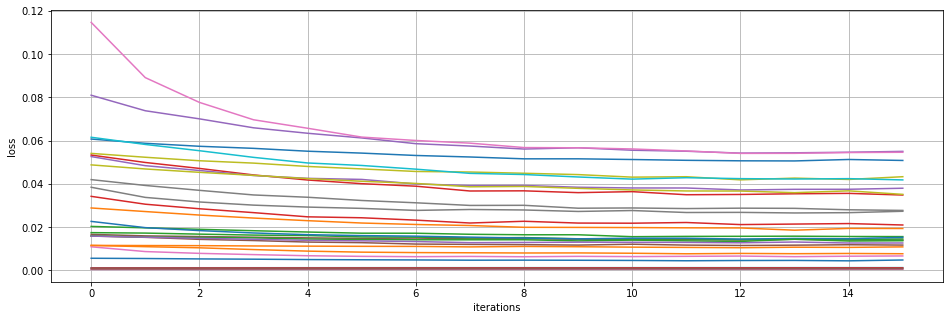

HGLOGNQ AND SONE  IS AN THE WOULD YOU WAS MOLE THE WOULD YOU WAS MOCT IN A MONT IN THE HAD YOU APEROT AND THE GENTIONED HIS FOHT IN THE WANT IN TO YOU ALONE I AN EVERY EHRES MENT AND THE JULD AND THE AND THE WOULD HAVE ME THE WAS MOHT DO YOU WERE IN A MOFT IN TO SHOW IN I AUL I MORS HAD HAD LOOKE RECOM IND THE WILL YOU WOULD HAVE CANT IN THE WOULD HAVE MAN OF MING AND THE MENT AND THE RESPECED BUT THE MENTIONE XACTE HAD YOU WITH THE ONAT HE SAID SHE IS AN THE CONTINUED AT YOU APENTING IT THE EMP
---------------
epoch 17
---------------
epoch 18
-----------------
average loss: 
[[0.05061808]
 [0.01092118]
 [0.01479824]
 [0.02056027]
 [0.05330118]
 [0.01439111]
 [0.00684079]
 [0.02633954]
 [0.04164422]
 [0.00133   ]
 [0.00461327]
 [0.02002635]
 [0.01436342]
 [0.03552204]
 [0.0374905 ]
 [0.0123649 ]
 [0.00057996]
 [0.02862378]
 [0.03607557]
 [0.04248946]
 [0.01474488]
 [0.00826604]
 [0.01410865]
 [0.00121214]
 [0.01274653]
 [0.00079292]
 [0.05541146]]


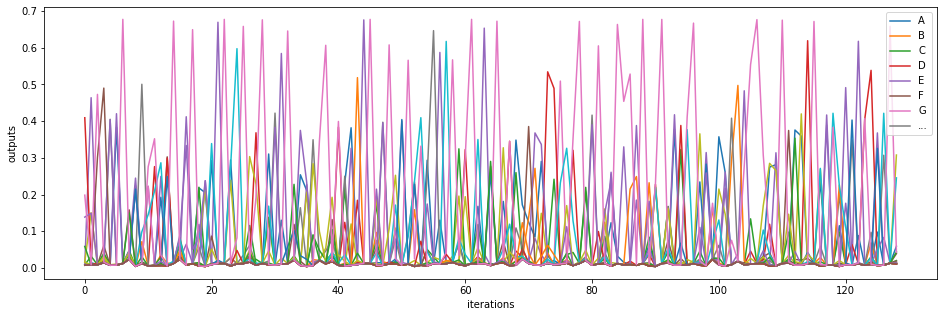

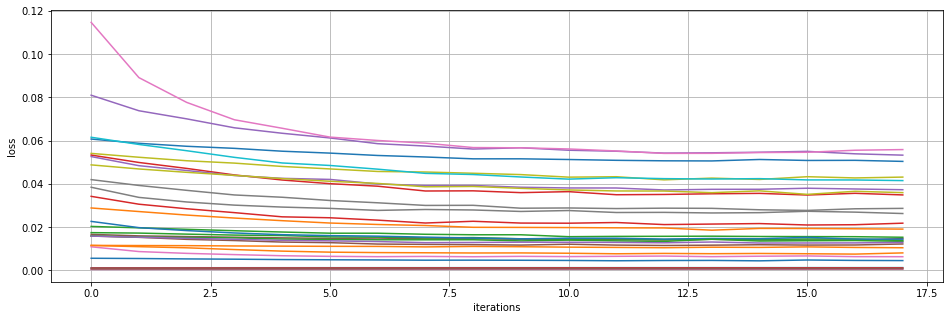

ONSE THE TO SO SHE SAID THE PRINCE AND NOT HIS SON IND THE BEIT BE WOULD HAVE BEEN WITH YOU WERE YOU WITH YOU WAN THE TO SO SHE SAY SHE LEAST IN A ALO THAT MY CONSENT PRINCE AND OF MO YOU FOR THE NOR AND OF MY CHILD I CONPERSATION AND FOR TO TO BE AN EMPRESS MENTING IN THE PRINCE AND I MOUNN CONSEYNA THE BEEN NOT IN A WAY MOUND AT I CONMINCE IT WITH SAID TO SOCIAE HAS BEEN NOT IN THE PRINCE REPECT HAS BURNT A PRINCUUG THE FOR THAT MENTING HIS KOUND HIS MOUT NOTHING I CAN TO SGCITIOUS IN THE PRIN
---------------
epoch 19
---------------
epoch 20
---------------
epoch 20
learning rate: 0.001
sample 401
output: 
[[0.01255502]
 [0.01241849]
 [0.01260253]
 [0.01260671]
 [0.01240823]
 [0.01240833]
 [0.0124107 ]
 [0.01241749]
 [0.01240824]
 [0.01240822]
 [0.0124085 ]
 [0.01241353]
 [0.01241418]
 [0.01245629]
 [0.01241282]
 [0.01264776]
 [0.01240822]
 [0.01243217]
 [0.01449342]
 [0.01260786]
 [0.01240827]
 [0.01240851]
 [0.01240918]
 [0.01240822]
 [0.01240822]
 [0.01240822]
 [0.67421066]]
targ

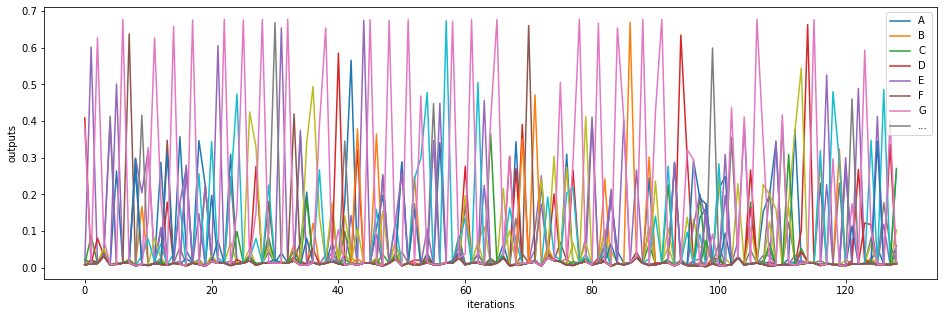

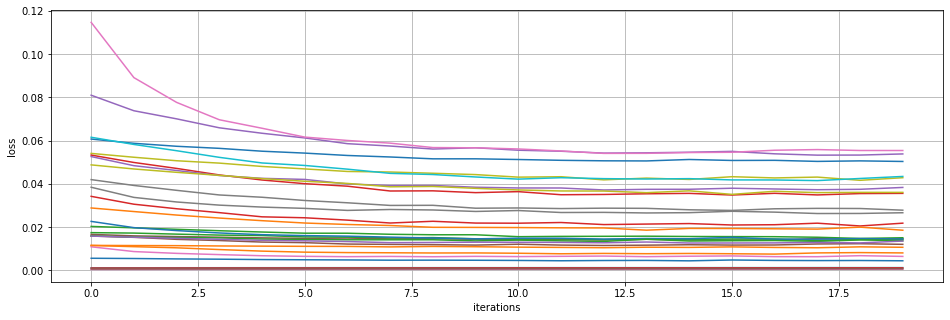

 AND IN A SHE AND IN A MEN BE TO SO EVER MO HAVE BE AN AND IM SHE AND YOU APPECTONG TO SUCH MORE THAT MY COULD TO SHOW I THE PRINCE WHAT IN I MATION AND IN THE PRINCE WITH SAY AND IN A DO YOU UN ROWN ENTHUS AND IN A SHAT EVEN IN THE CHILD I HALL SHE UNDERSTOME  SHE BUONA AND AND I DONT ZEARECH THE CONTINUER AND I DO THE PRINCE WITH SHE ENTIONT SINCE TO IN THE BUON A COULT IT BE THE PRINCE WITH SHE LIOK AND I DO THE PRINCE WITH SAID THE PRINCE AND IMZITING AND IN A SEURE AND I MORE TONE AND I COU
---------------
epoch 21
---------------
epoch 22
-----------------
average loss: 
[[0.05080496]
 [0.01069691]
 [0.01570459]
 [0.0218554 ]
 [0.05526736]
 [0.01431432]
 [0.00683478]
 [0.02636686]
 [0.04318577]
 [0.00132326]
 [0.00469241]
 [0.01970324]
 [0.01458601]
 [0.03596067]
 [0.03886293]
 [0.01214692]
 [0.00058495]
 [0.02968847]
 [0.03686546]
 [0.04259885]
 [0.01514568]
 [0.00840176]
 [0.01404957]
 [0.00122334]
 [0.01280966]
 [0.00079795]
 [0.05841213]]


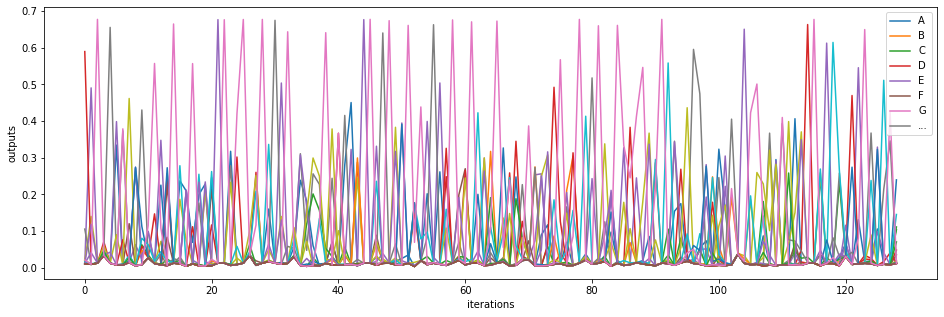

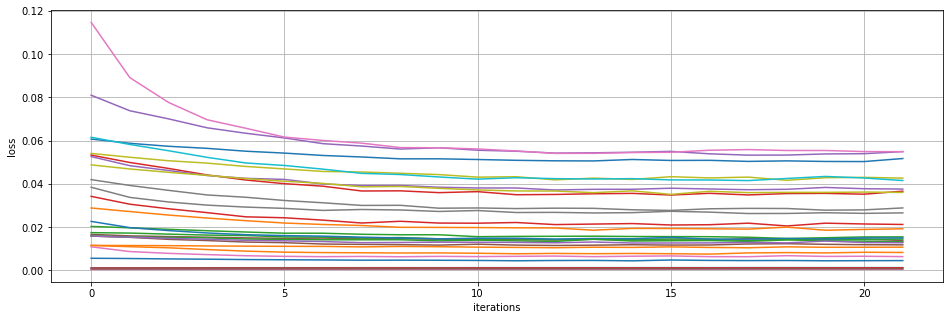

SE THE SAD ED YOUR FACHINGHT ALL AND THE THAN THE THAN AND SHE SMED I COULD ILLE COULD  XOMORE CANT OL IF YOU NO LO THE SAID A TO OF GHIT HIS SIDED AT EUROLE OUR FOR TO THER THER TO TO IT SHE IL SHE IS AND THE SMEAD HE SAID THE SAID IN THAN WITH THE RAN MOTINB UND YOU WITH THE LEAST MEAT THE PRINCE WHE WITH THE  QSAE AND THING I COULD FOLLO AND THATED THER TO YOU ALON AND THATTING I DATE THAN MELLY CHEL DENT AND CRATH THE PRINCE AND SHOUL I HAD CHELD TO SO CONTHAT ESSIOS JOST SHER AND CHILD THE 
---------------
epoch 23
---------------
epoch 24
-----------------
average loss: 
[[0.05087512]
 [0.01058331]
 [0.01554766]
 [0.02157092]
 [0.05528942]
 [0.01443979]
 [0.0067228 ]
 [0.02770582]
 [0.04314493]
 [0.00133373]
 [0.00472826]
 [0.0195538 ]
 [0.01425561]
 [0.03553805]
 [0.03928196]
 [0.01194909]
 [0.00059161]
 [0.03027515]
 [0.03700481]
 [0.04329492]
 [0.01547826]
 [0.00821654]
 [0.01407584]
 [0.00123653]
 [0.01310417]
 [0.00080391]
 [0.05700711]]


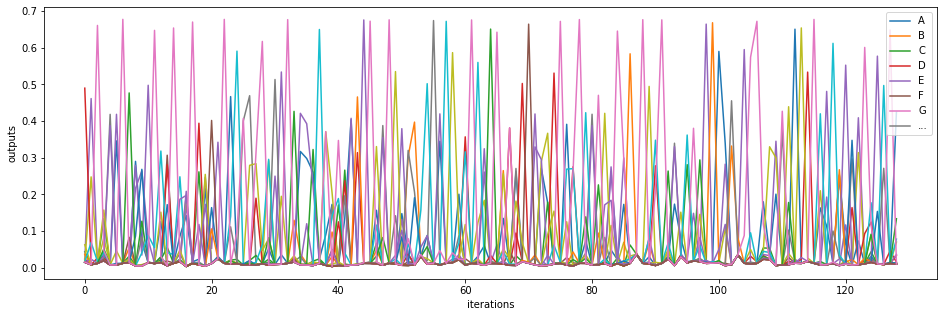

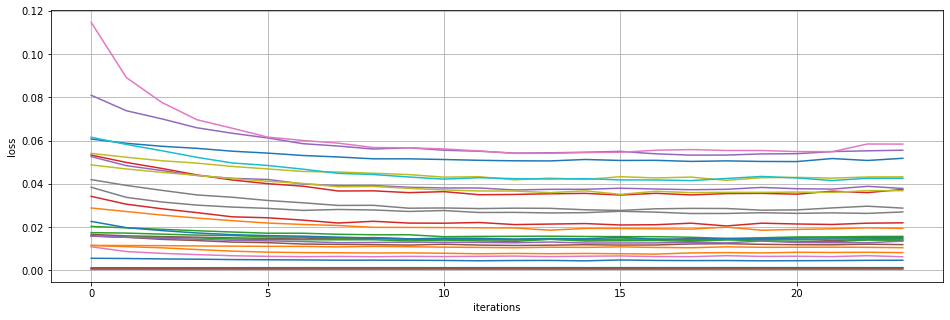

H YOUR PRINCE AN EVER I CONSILL SAID THE PRINC COMUST AND WHE WJUST THE WHE WAS ROON AND CRRECOON AND THE PRINCE WEAL TO SHE ZAS SHE HAS IN AND THE EMPECTER BEEN HAVE TY CHARWE SHE HAD DES CARO SHIN PURTHE ALL AND BEARTY DESITIIT SOR SHE ADDED IN THE EMPRESS IN THAT YOU AND EVER WITH YOU WOULD AT MY DOWT SAID IN AND THE PRINCE WHICH COMPENDERS AND THE FOR THE WEALING I SON TO SHE VEROINT WCOULT YOU DAKY DAZING EVERY COME CANT CONSLLEN JUST YOU AND YOU WAT UST SHE WHO I COURGECK WITH YOU WAITH I 
---------------
epoch 25
---------------
epoch 25
learning rate: 0.001
sample 401
output: 
[[0.00616449]
 [0.0061686 ]
 [0.0061863 ]
 [0.00627125]
 [0.00615987]
 [0.0061596 ]
 [0.00615904]
 [0.00616573]
 [0.00615952]
 [0.00615902]
 [0.00623497]
 [0.01220489]
 [0.0061591 ]
 [0.05109891]
 [0.00615903]
 [0.00619616]
 [0.00615902]
 [0.33291501]
 [0.00914961]
 [0.17277914]
 [0.00717929]
 [0.00615904]
 [0.00615904]
 [0.00615902]
 [0.00615902]
 [0.00615902]
 [0.29121633]]
target: 
[[0], [0], [0], [0],

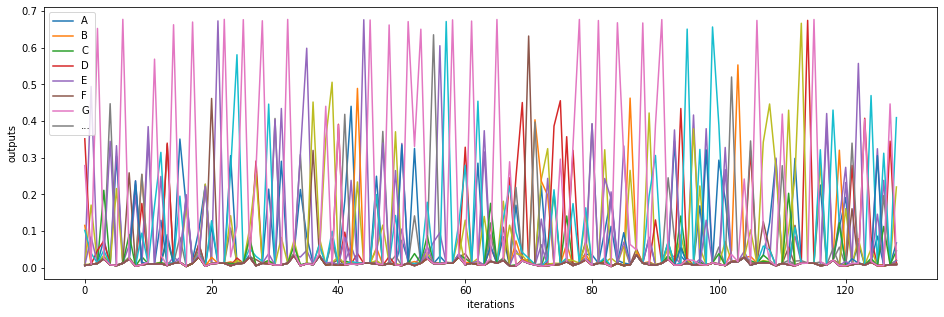

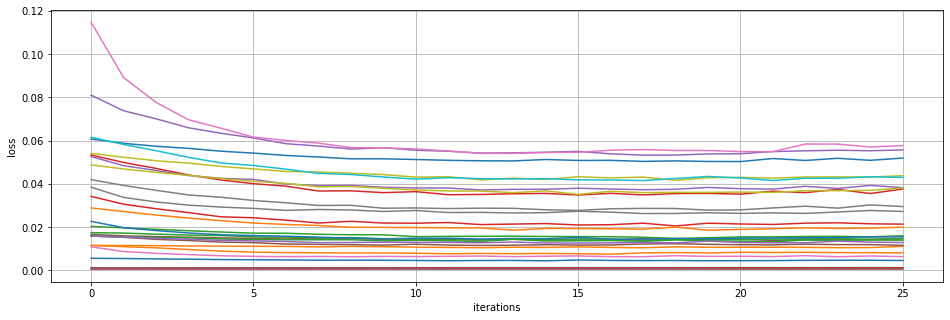

SHE AD THE SAID THE S AND I HER SON BETOWE AND THE SAID THE SAID IT THE RESPECT YOUR FAITH IS TO YOU ALOFE I COUST USD THE SAID IN AVE IN A TO DOWN AND THE WAS ALL SHE SMILING I SHALY AND IT I THE MEN ONE THAT MY CZISH TO YOUR FOO KE AND THE SAID I HAVE THE ALOLE I AL SMILE  IN THING DED THING IN A MAN TO YOU ALO DE SIT IS THE XPPINTED THAT THE FIRST IS TO ME THE SAID IT TO MREPRINE SAT HIAS COLST IS TO SHE WEREMED THE EMPRECS AND TO THE PRINCE MEANT TO ME TO SHOW IN A TO ME THAT IT SIME THE WHI
---------------
epoch 27
---------------
epoch 28
-----------------
average loss: 
[[0.05065732]
 [0.01072358]
 [0.01578763]
 [0.02175643]
 [0.05601058]
 [0.01452202]
 [0.00656503]
 [0.02651506]
 [0.04331661]
 [0.00133383]
 [0.0045112 ]
 [0.0194614 ]
 [0.01453857]
 [0.03656714]
 [0.03835094]
 [0.01172387]
 [0.00059746]
 [0.02900904]
 [0.03792147]
 [0.04308386]
 [0.01564878]
 [0.0080488 ]
 [0.01360965]
 [0.00124112]
 [0.01306143]
 [0.0008141 ]
 [0.05695397]]


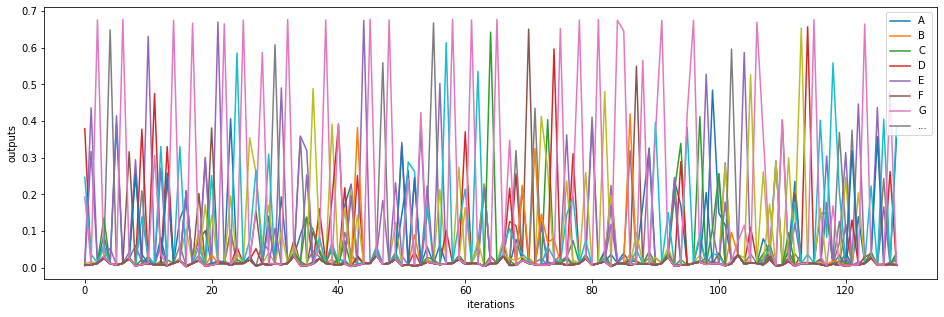

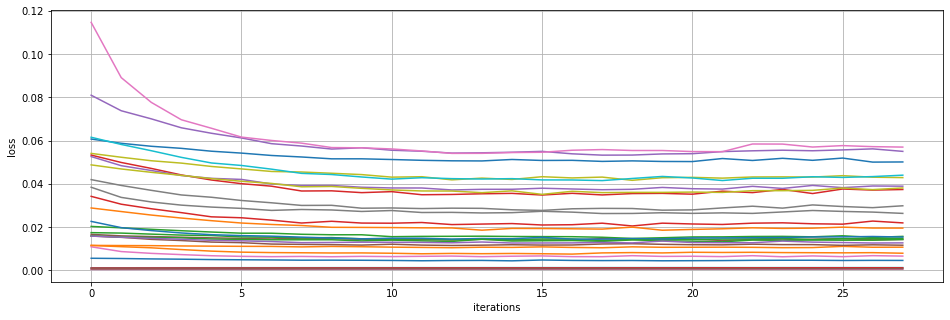

AT IT SAID THE PRINCE AND THE PRINCE AND ICALL TO INDICATE TO JUST TO KE HAVE MAT THIS VICOME NOT AND THIS QOUARED AND DISAPPOORTED AND AND TO YOU THE WILL YOU NAPROBLE IT FACE GERED IT TO ME TO YOU JUST TERER  AED THE PRINCE AND EVLNA INDLY I CANTICHATTING RESS SHE XBEALIAL THAT TO YOU LIOD QEENT TO WHAT THE SAIDED AND TO YOUR WENT I SHE IT TPOLITE IT OUR EVERY INDING PREST INDED THE PRINCE AND GRIYS XLQASSIMED TO KE HER MY SHE VOCITION OF THE YOU WOULD TO TO AT HAVE A WITH THE  PRINCE AND CHIL
---------------
epoch 29
---------------
epoch 30
---------------
epoch 30
learning rate: 0.001
sample 401
output: 
[[0.01226447]
 [0.01231331]
 [0.01226448]
 [0.01232674]
 [0.01226342]
 [0.01226341]
 [0.01226342]
 [0.0122639 ]
 [0.01227134]
 [0.01226338]
 [0.01226383]
 [0.01226887]
 [0.01227052]
 [0.01398448]
 [0.01226365]
 [0.01227004]
 [0.01226338]
 [0.02194038]
 [0.01242531]
 [0.01226618]
 [0.01226338]
 [0.01230022]
 [0.01226341]
 [0.01226338]
 [0.01226338]
 [0.01226338]
 [0.66940832]]
targ

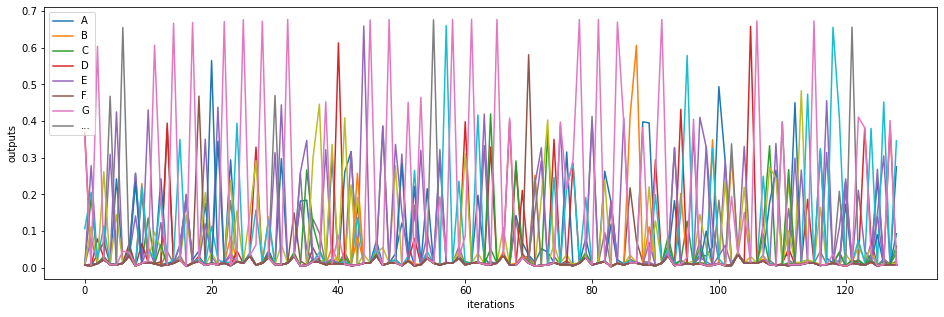

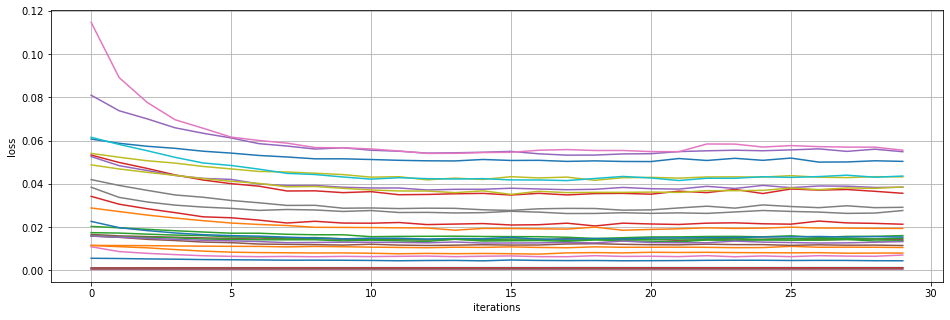

AND THING  ROSPECT DONT IN THAT VENY CH IMPUSTION OF SO SHE VECOME SHE RESS THE XMENGJNW BY AND QU A FAME THE PRINCE VOCITED EVERY INTER PITHE JUST UNNAPPATTY A SHE WPACT EGRER MHING  THE PRINCE ALE LISVE HE SAID THE PRINCE CHARORNENCIT A COURTE THE LAVE A FOR TO AND THE LAVE IT FOR INDDED THE PRINCE ENTHE  JONE  IN THE QAED AND YOU COULD NOT HE WITH SAID AUT AND IN THE GESTAIN OF AND THE PRINCE THE FAMK YOU CHILD GOKE A MAN ONE THE PRINCE KNEE HER I CHAS THE PRINCE SO SHE IND JUST LE FACON ENDM
---------------
epoch 31
---------------
epoch 32
-----------------
average loss: 
[[0.05262267]
 [0.01050348]
 [0.0167287 ]
 [0.02266834]
 [0.05659503]
 [0.01417936]
 [0.00679985]
 [0.02755706]
 [0.04329084]
 [0.00136123]
 [0.00455311]
 [0.01918113]
 [0.01535184]
 [0.03828624]
 [0.03881975]
 [0.01194025]
 [0.00060554]
 [0.02923433]
 [0.03890591]
 [0.04365848]
 [0.01608755]
 [0.00827277]
 [0.01413721]
 [0.00125018]
 [0.01353524]
 [0.00082997]
 [0.05878997]]


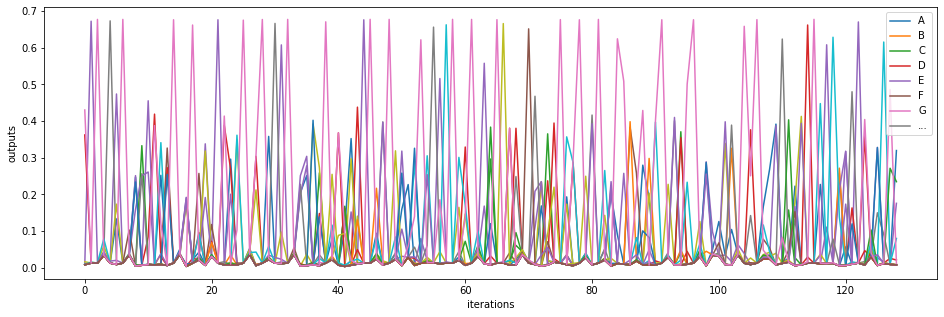

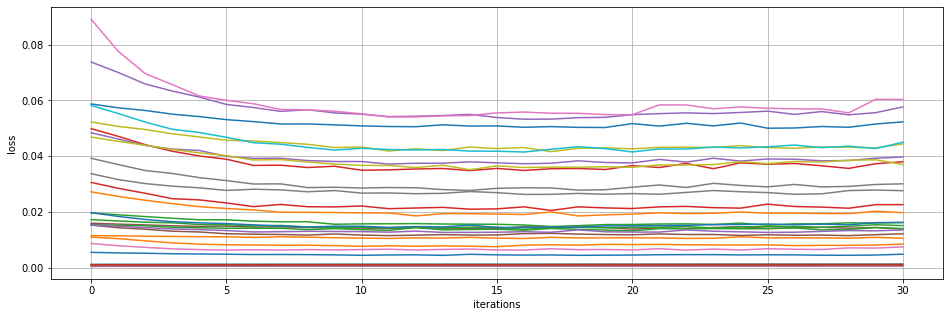

H YOU AND THE PRINCE DECOANCE DO HAD ONE WITH THE PRINCE FIMNE THE HAVE FAITH I DONT TO KNE WOULD FAID THE PRINCE LOFTING A MAN OF MY HER IN A SOUL I COURT COULD THE PRINCE THE KNE WAS IN A THE ZESS WITH YOU FAINLING THE PRINCE OUR FORLIES A COUR OUR DES SHE ADDENE BETWEEN THE PRINCE WEPE I DONT CHER MEN AND THE PRINCE CHOR MAID  IT GONBE AND THE PRINCE OF RECOLE THE PRINCE XILE THE UND SHE SAID TO SHE SAID THE PRINCE DED TO SHE WHE DOME THE WHO WO MWOUT ZORS IN A OLQ YOU AND MJORCE THE PRINCE G
---------------
epoch 33
---------------
epoch 34
-----------------
average loss: 
[[0.05113189]
 [0.01080042]
 [0.01638515]
 [0.02223753]
 [0.05663121]
 [0.0145518 ]
 [0.00675216]
 [0.0280355 ]
 [0.0450788 ]
 [0.00136483]
 [0.00476986]
 [0.02049342]
 [0.01453197]
 [0.0371061 ]
 [0.0403377 ]
 [0.01244101]
 [0.00061872]
 [0.03007714]
 [0.03880333]
 [0.04455405]
 [0.0160253 ]
 [0.00797083]
 [0.01374032]
 [0.00124505]
 [0.01385101]
 [0.00084111]
 [0.059204  ]]


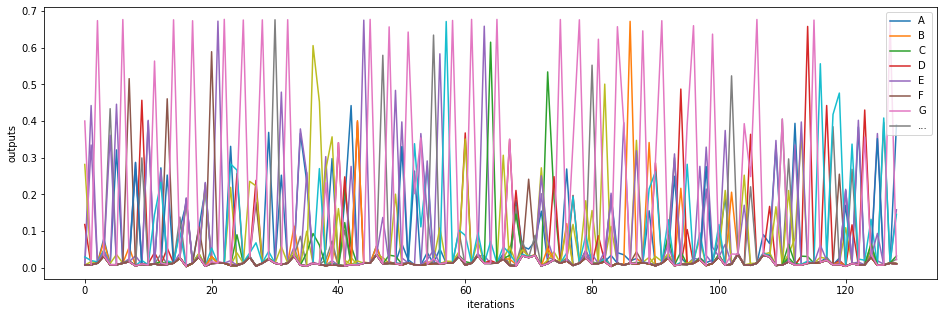

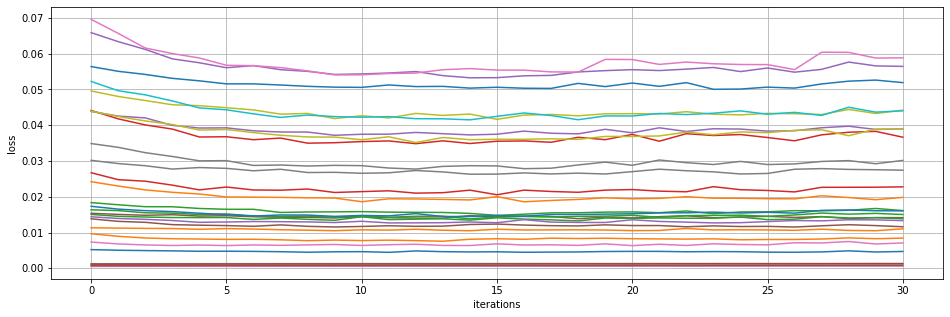

 IF THE I IS A THE REXPOLYTITED TO SHE SAID THE A SOME TO SIZE SUMED A MART WOULD STALI MOUTD HE SAID CHILD FAMILON WHAT SHOW IN A ALO SHER ILL AND JULGITUAUT I MATER UNDIFPEED TOURED TO CALM YOUR FOR THING I NATHE HE SACION TOY YOU AND SOME IN THING I CHOROWITH YOU  AND SONIFUL  IT PINCOME THE PRINCE PRINCE WAS IN THE ENGERING IT GAID I HAVE VERY CQURD TO SUFNED THE BUMP A HAD QUEETITH TO SIFT UUD IN A FOX ZIFUS AND YOU YOU AND YOU GORION  CAN HE WER IN A ALO SHER SHE YOU  AN A MCALY TO SHE SAI
---------------
epoch 35
---------------
epoch 35
learning rate: 0.001
sample 401
output: 
[[0.01542184]
 [0.00738418]
 [0.23598757]
 [0.00737515]
 [0.00737821]
 [0.00744255]
 [0.00736569]
 [0.00750411]
 [0.00736977]
 [0.00736553]
 [0.00739877]
 [0.27888621]
 [0.00736598]
 [0.02548564]
 [0.00742403]
 [0.27847644]
 [0.00736553]
 [0.0093944 ]
 [0.00736662]
 [0.00840404]
 [0.00736554]
 [0.00736563]
 [0.00745795]
 [0.00736553]
 [0.00736553]
 [0.00736553]
 [0.00755204]]
target: 
[[0], [0], [0], [0],

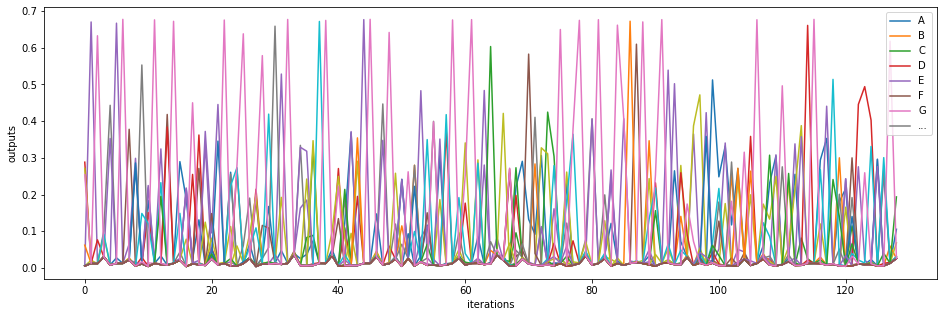

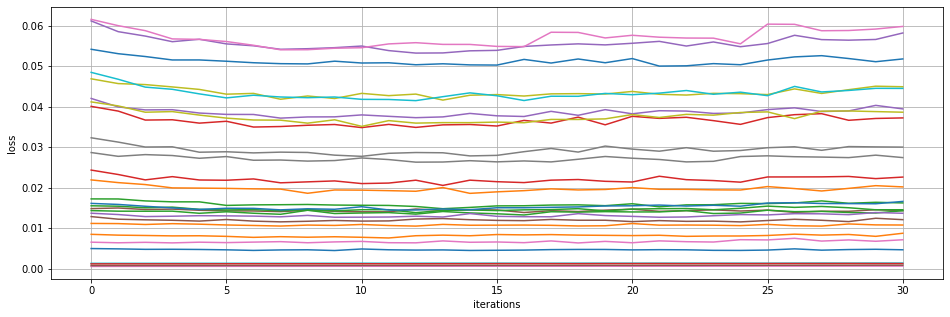

 MERED IT YOU JUST EVENT THE ZIME ME BUONE ALL AND YOU ARE STILE  THE BERONE THE  ICALL THE BANE OF  IN THE  INDIFPERTING I AND BELY I DONT LOFORED BY AND IF YOU ALLOF INTIFSED TO OF THE EMPRINCE FINBUT GERED KNEW I MAN OF YOU PRINCE IND THE SEE THAT IT SZE SHER HIS SOMPITT MY OF JULK  I AN AND IMPOULNA PRINCE I AXPLAYSH  THE ZIMS AND THE CHILD SILLY YOU ARE TO SUCH SROULD HOF OUR YOU WAS SOME SHE ZIME DONT CAN CONICONE IS XAOTH INCAUP SO HE SAID THE REPLEDFEDSS THE VOCFROUO PRINCE THE VERY I AC
---------------
epoch 37
---------------
epoch 38
-----------------
average loss: 
[[0.05188915]
 [0.0112725 ]
 [0.01648225]
 [0.02304976]
 [0.0578983 ]
 [0.01485958]
 [0.00703525]
 [0.02813579]
 [0.04474343]
 [0.00137538]
 [0.0048428 ]
 [0.02116757]
 [0.01518899]
 [0.03891865]
 [0.04026195]
 [0.01196898]
 [0.00062483]
 [0.03156758]
 [0.03973608]
 [0.04736669]
 [0.01586402]
 [0.00809606]
 [0.01366117]
 [0.00125533]
 [0.01366858]
 [0.000853  ]
 [0.06153319]]


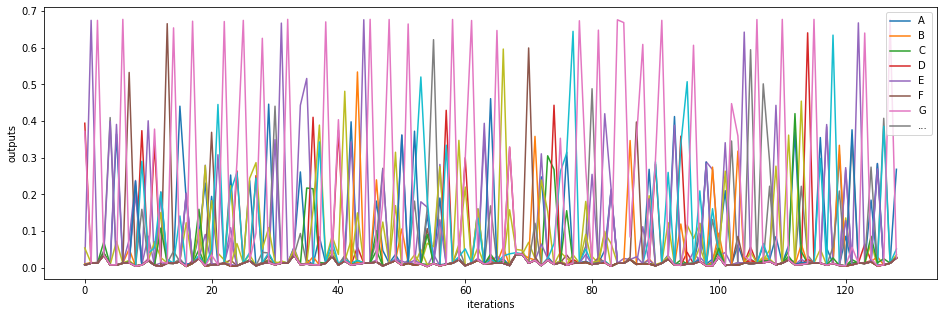

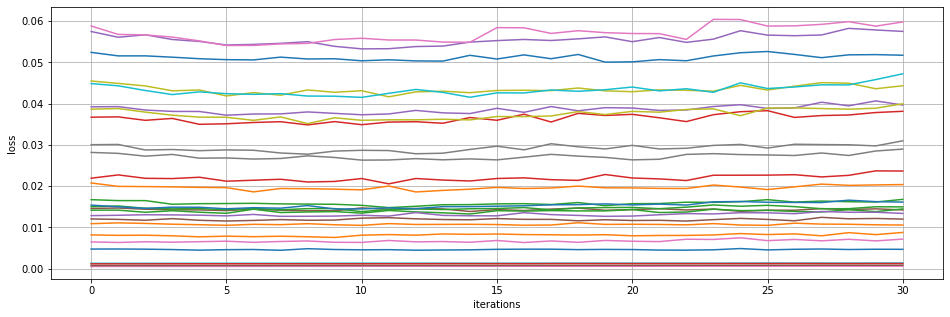

Y A CONE THE UNDED A PROFOUND TONE A SHE AS AND AND BURPPERIND TO SINCERED A SHE SAID AND SO IN A MATED THE QEEOTATION AND COULD GRAND AH SHE SAID AND SHE SMILE IT  THE PRINCE LOWED REPE PEROALINA UND SMALED MOURT IS OUR SOCIRED INDIFPERED THAT INATED DED A SHE SHE SAID AND ALL SHE SMALL TO IT INRY DESTILL SID AND RELID AND VERY CAN EMPRESS I HAVE KN SHE SHE SMARE WITH SHE SHE SAID AND INRECOME SO VERE SHE SMALE IT ZIFER IT THE BUONAPPRJSS AND TO SHE SAID AND UNDED YOUR FOR GIT IN A GOHT LOWT I 
---------------
epoch 39
---------------
epoch 40
---------------
epoch 40
learning rate: 0.001
sample 401
output: 
[[0.00871962]
 [0.00867422]
 [0.02599193]
 [0.00891947]
 [0.00867399]
 [0.0086743 ]
 [0.00867403]
 [0.00870567]
 [0.00867403]
 [0.00867399]
 [0.00867422]
 [0.00868139]
 [0.00867414]
 [0.09730763]
 [0.00867399]
 [0.00868104]
 [0.00867399]
 [0.00867448]
 [0.00872379]
 [0.20323809]
 [0.00867399]
 [0.00867417]
 [0.00867426]
 [0.00867399]
 [0.00867399]
 [0.00867399]
 [0.47357157]]
targ

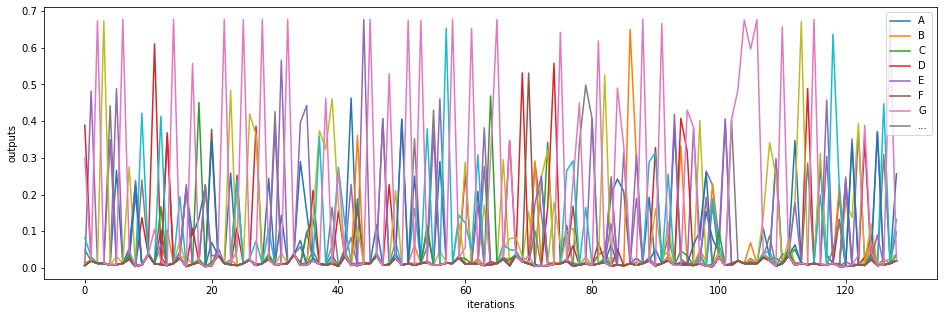

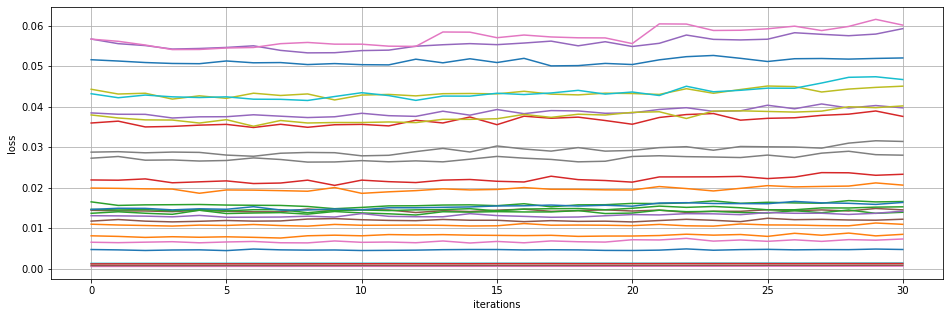

AND IN AND WOULN LE IS AND NOW JUST OF TO SOCIWICH  XONE BEEN TO PRINCE AND THE TO  PRINCE BE HONE AND ON ENKECHE IN AND IBE THE DESPECT IN THE MEN THE HAVE VERY CHARE LOOKEN WH WITH YOU BUT TO TURED THE ONE AND BEAT TO KCER KURG SHE SAID THE VEN WITH IN A HARING IN AND PRINCE A XPELTAT I SHE SOME DAY AND BOTHED VISIT AND HIS BUT QUED TO TO ZE HE SHE SAID AND THE  I FOR TO  THE LEAST ZOW SILE THE GENTING PRINUNG IN THE DID NOW A SUAL EVERY CONSHE  AND CHAL IT IT I ULONE RENED THE NOW AND I YOU Q
---------------
epoch 41
---------------
epoch 42
-----------------
average loss: 
[[0.05345169]
 [0.01093078]
 [0.0167346 ]
 [0.02632405]
 [0.06124971]
 [0.01478488]
 [0.00717472]
 [0.02893317]
 [0.04632676]
 [0.00137809]
 [0.00472505]
 [0.02189926]
 [0.01565708]
 [0.04057508]
 [0.0410382 ]
 [0.01265111]
 [0.00063053]
 [0.03318794]
 [0.0421495 ]
 [0.04739864]
 [0.01704427]
 [0.00952646]
 [0.01489111]
 [0.0012647 ]
 [0.01431021]
 [0.00085666]
 [0.06511982]]


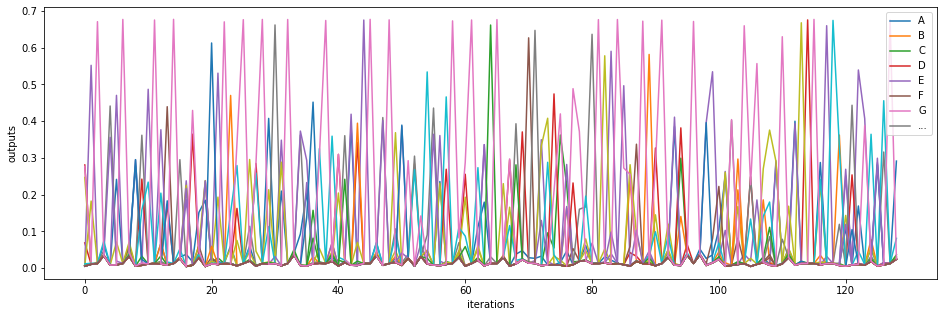

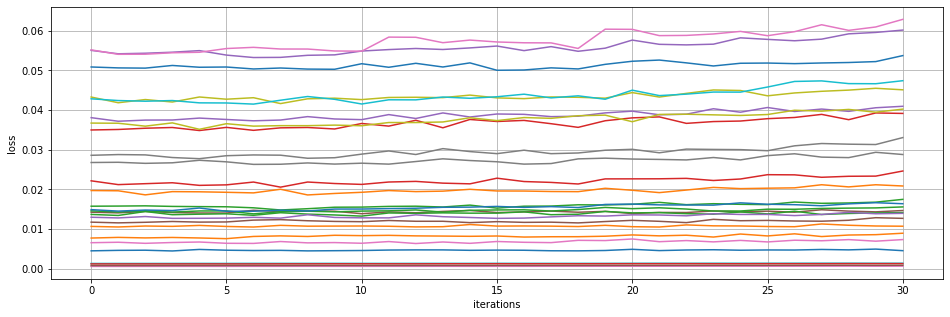

U WOUL ED TO I FAUL SAID THE LGAK I  UNDERDED THE DOWA I WHILD S SHAD AND TO SECRIING ION  I VOCALY FOR THAN AND  IMPEATION THE APPOFIRED THE HDAVE HAVE VAGITIT SAID THBUTOUT NOT THE NOT HADKED ED IN AND I I MEAN FOR TO THE REPLIED THE PRINCE GRES CONSIWILL IN A AL AEAVE IT THE BARON FARLY EVEREPRY IN THE VGEN IT TO SECREATIING TO SHOW I AND SIME AND TO TO SEATED KENOULD AND THE DOWA IN A SAIDERED BEXWEN I US THE DESPED IN AN EVEREPRING I HE SAID IN A MANTOJ THE IS AND ACTOMERED I HAVE EMPERAOLL
---------------
epoch 43
---------------
epoch 44
-----------------
average loss: 
[[0.05424251]
 [0.01122682]
 [0.01798391]
 [0.02503244]
 [0.06183589]
 [0.01558904]
 [0.00744255]
 [0.02938716]
 [0.04638366]
 [0.00138377]
 [0.00504534]
 [0.02176376]
 [0.01579964]
 [0.04069507]
 [0.0422558 ]
 [0.0128841 ]
 [0.00064892]
 [0.03258053]
 [0.04155621]
 [0.04941743]
 [0.01652886]
 [0.00916061]
 [0.01479591]
 [0.00128669]
 [0.01396901]
 [0.0008696 ]
 [0.06672432]]


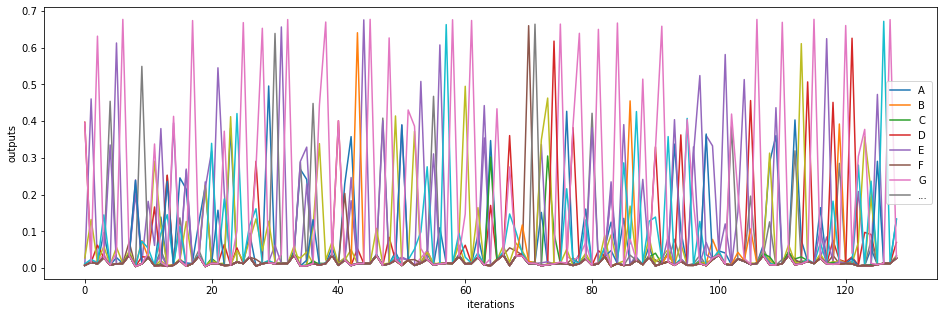

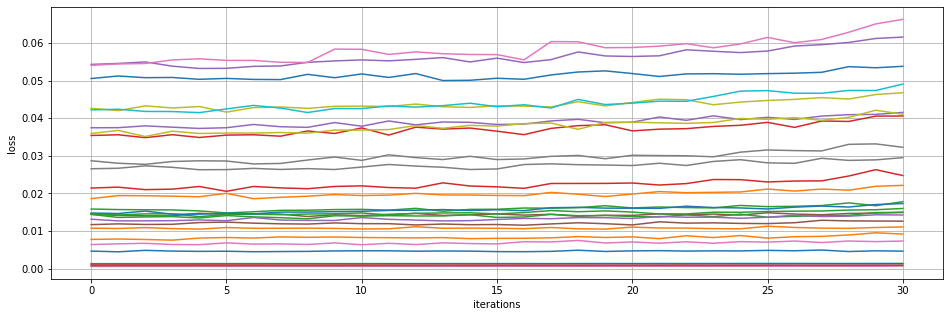

OF YOU ETPW A SARY EMPRESS THE PRINCE QOULI AND XO SHE WITH NOTHE PRINCE THE ED NOT THE WOULD SO MAID COULD QUEG THE PRINCE A THE MORED TH JOOK QUEETING THING THE  IM SAT PRINCE US A WAT THE RENOT AND JUST SHE AOD AND XI A MAN ONE TO PRINCE WOULD HE SAID YOU HAD MAID TO SHE ZOULD FAND THE MENT HE WITH MIST WANTER SHE NOT A JURG FOR HE LACK THE LAFT IN A WOULD  BECOFE KURGER VERIVE IT THAT I SHE HE SAID TH HAS LOOUDDED WITL CHAL THE ZE HER RECOME IN QUEDTE THAT IS AN AND THE SAID A TS MORSE S A S
---------------
epoch 45
---------------
epoch 45
learning rate: 0.001
sample 401
output: 
[[0.00690687]
 [0.00604443]
 [0.00651088]
 [0.32021592]
 [0.00604052]
 [0.00603629]
 [0.00603714]
 [0.00603683]
 [0.00606888]
 [0.00603626]
 [0.00604282]
 [0.0062117 ]
 [0.01118642]
 [0.00952438]
 [0.00603743]
 [0.00603656]
 [0.00603626]
 [0.00690515]
 [0.02259623]
 [0.18286319]
 [0.00603626]
 [0.00603782]
 [0.00603631]
 [0.00603626]
 [0.00603628]
 [0.00603626]
 [0.32440665]]
target: 
[[0], [0], [0], [0],

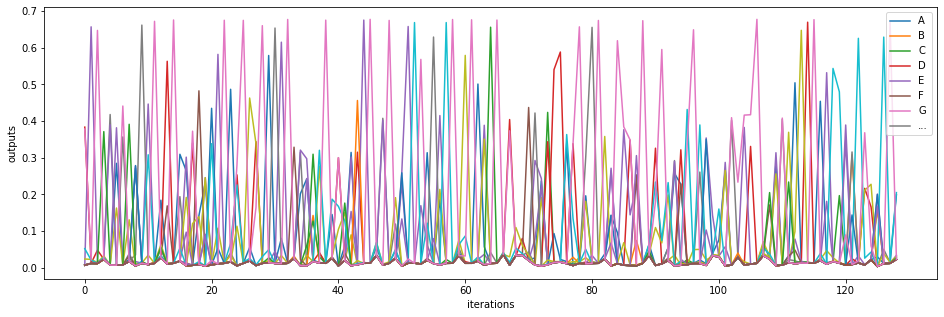

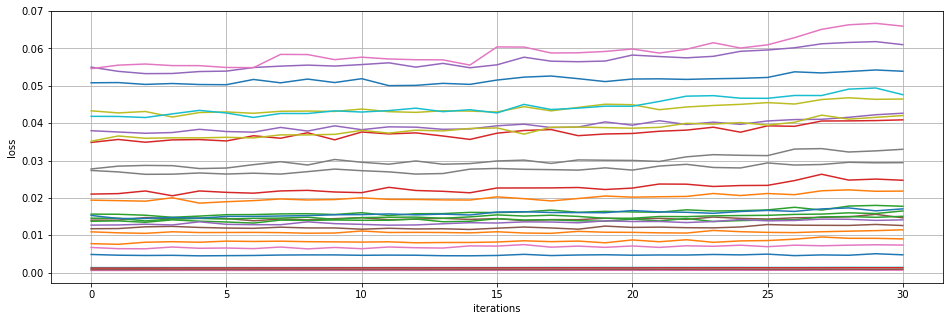

 SAID POQITE AND UNDERYSED THE SAID HOW JUST QEENT I THE CONTER FAITH CONTED YOU OF AND VISTNED WITH HING THE HAVE PRINCE ZALE CONT SEARE QUESTOOD AND DIH DID RES AND KNE PRIICING OUR UNDERSTY AND THE BARON FUNIT JOKE IN AN A  WITH THE KONW ZIOUD SONS MITE DO VERY HAS FUL SLA ALL A KNOW AND TO IT UF TO ME TO ME THE PRIN CONSED ONE THAT  LOKE AND AND FINCED THE PRINCE HIS ZANCENT IN AN ACTIJURG NOIT GRES AND MORE INBUT AND TO XERSIST IN ANJE BERY REST BEJOCH EMPRES THE ZEOSS AND TO QRIEESS TONPUC
---------------
epoch 47
---------------
epoch 48
-----------------
average loss: 
[[0.05462471]
 [0.01139609]
 [0.01751155]
 [0.02546297]
 [0.06161667]
 [0.01494802]
 [0.00725935]
 [0.0292585 ]
 [0.04698309]
 [0.00139521]
 [0.00468605]
 [0.02234858]
 [0.01612919]
 [0.04225129]
 [0.04316701]
 [0.01286481]
 [0.0006464 ]
 [0.03230442]
 [0.04251976]
 [0.0494628 ]
 [0.01700354]
 [0.00902852]
 [0.0147787 ]
 [0.00130015]
 [0.01422499]
 [0.00087203]
 [0.06762316]]


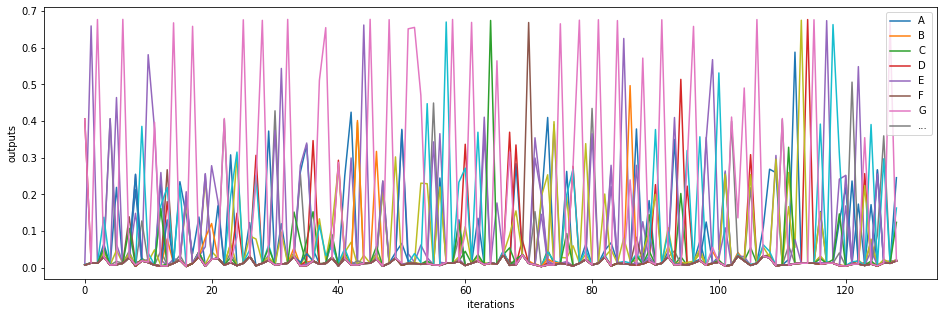

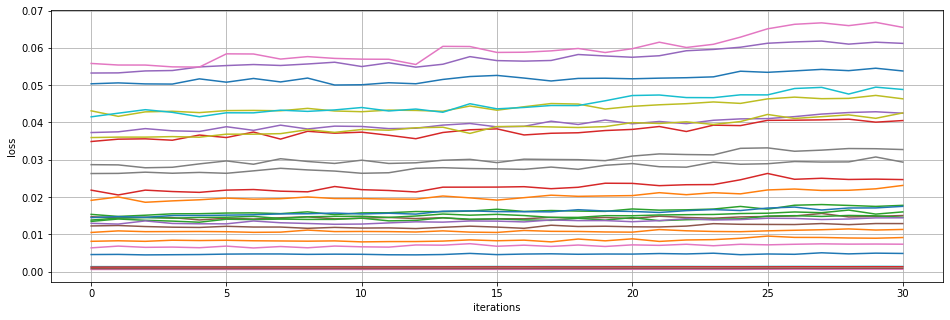

 EVERT WOELD WILL SISERED SOME SHE SAARE PRINCE LISTED THE SAID MOUT CHLY IS XENK AND  BY SPENDED WOULD AND THE UNDERETERS AND DO SO ZITH THE ONE SHE SAID TO FERS TO  UNDIFPED TO NEQS IT SAID THE WAS AS SHOULGE ME TO SQOED AND FACE STERBER THE WHE SAID THE PRINCE VERY KSO SHOW INWILKE TO SECUED AND THAT HE SAID THE JOME AND ZOULD WDO AND UXPORESSTORED SHE SAID TO IS DONT SISIDED AND AND QAITA XAN BE A COULD LIST IS FOUKNG TO KONE WHE XANCIMASTION AND AND OFAAND THE RED XO YOU UF THI MEN THE PRIN
---------------
epoch 49
---------------
epoch 50
---------------
epoch 50
learning rate: 0.001
sample 401
output: 
[[0.01933884]
 [0.01929621]
 [0.01953555]
 [0.48330782]
 [0.01928919]
 [0.01928905]
 [0.02177584]
 [0.01931447]
 [0.01953434]
 [0.01928905]
 [0.01929915]
 [0.02298041]
 [0.01948014]
 [0.01943783]
 [0.01928905]
 [0.01931956]
 [0.01928905]
 [0.01940902]
 [0.02005758]
 [0.02617968]
 [0.01928905]
 [0.01929233]
 [0.0192893 ]
 [0.01928905]
 [0.01928905]
 [0.01928905]
 [0.01955036]]
targ

In [ ]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.0000
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        if i > len(input_data)-1 - 130:
            outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 55, i+1)
  
        if e%5 == 0 and (i+400)%801 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%2 == 0:        
        print("-----------------")
        print("average loss: ")
        print(str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.legend(["A", "B", "C", "D", "E", "F", "G", "..."])
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    losses.append(loss/len(input_data))
    if e > 30:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-3].inputs))

In [ ]:
print(str(network.layers[-1].bz))

In [ ]:
print(str(network.layers[-1].br))

In [ ]:
print(str(network.layers[-1].Wz))

In [ ]:
print(str(network.layers[-1].Wr))

In [ ]:
print(str(network.layers[-1].Wh))

In [ ]:
print(str(network.layers[-1].Ur))

In [ ]:
print(str(network.layers[-1].Uz))

In [ ]:
print(str(network.layers[-1].Uh))

In [ ]:
print(str(network.layers[-1].bh))